In [127]:
import numpy as np
import matplotlib.pyplot as plt

In [128]:
def build_lattice(x_molecules, y_molecules, lattice_spacing):

    coordinate_list = []

    for index in range(x_molecules):
        for index2 in range(y_molecules):

            coordinate_list.append([index, index2])

    coordinate_vector = np.array(coordinate_list)
    coordinate_vector = coordinate_vector*lattice_spacing

    return coordinate_vector

In [129]:
def DA_index(coord_vector, donors, acceptors):

    total_molecules = len(coord_vector)

    donor_indeces = [index for index in range(total_molecules)[:donors]]
    acceptor_indeces = [index2 for index2 in range(total_molecules)[donors:]]

    return donor_indeces, acceptor_indeces

In [130]:
def build_connectivity(coord_vector, max_distance):

    connectivity_list = []
    
    for index in range(len(coord_vector)):

        if index == (len(coord_vector) - 1): break

        for index2 in range(index + 1, len(coord_vector)):

            euclidean_distance = np.sqrt((np.sum((coord_vector[index] - coord_vector[index2])**2)))

            if euclidean_distance <= max_distance:

                connectivity_list.append([index, index2])

    return connectivity_list

In [131]:
def define_CT_states(donor_list, acceptor_list):

    state_list = []

    for element in donor_list:
        for element2 in acceptor_list:
            state_list.append([element, element2])
    
    return state_list

In [132]:
def define_XT_states(molecule_list):

    state_list = []

    for element in molecule_list:

        state_list.append([element, element])
    
    return state_list

In [133]:
def build_CT_block(state_list, coord_vector, connectivity, interaction_constant, coupling_constant):

    number_states = len(state_list)
    H_matrix = np.zeros((number_states, number_states))

    for number in range(number_states):

        for index in range(number_states)[number:]:

            if state_list[number] == state_list[index]:

                donor_molecule = state_list[number][0]
                acceptor_molecule = state_list[number][1]

                euclidean_distance = np.sqrt((np.sum((coord_vector[donor_molecule] - coord_vector[acceptor_molecule])**2)))
                single_lattice_distance = np.sum(coord_vector[1] - coord_vector[0])

                euclidean_distance = euclidean_distance/single_lattice_distance 

                H_matrix[number,index] = (interaction_constant)/euclidean_distance
                H_matrix[number, index] = H_matrix[number, index]/2

            elif (0 in np.subtract(state_list[number], state_list[index])):
                
                for element in connectivity:
                    if (state_list[number][0] == element[0]) and (state_list[index][0] == element[1]):
                        H_matrix[number, index] = coupling_constant
                        break

                    elif (state_list[number][1] == element[0]) and (state_list[index][1] == element[1]):
                        H_matrix[number, index] = coupling_constant
                        break
    
    H_matrix = H_matrix + H_matrix.T

    return H_matrix

In [134]:
def build_XT_block(state_list, connectivity, interaction_constant, coupling_constant):

    number_states = len(state_list)
    H_matrix = np.zeros((number_states, number_states))
    
    for number in range(number_states):

        for index in range(number_states)[number:]:

            if state_list[number] == state_list[index]: 
               H_matrix[number, index] = interaction_constant/2
            
            else:
                for element in connectivity:

                    if (state_list[number][0] in element) and (state_list[index][0] in element):
                        H_matrix[number, index] = coupling_constant
                        break

    H_matrix = H_matrix + H_matrix.T

    return H_matrix

In [135]:
def build_XT_CT_block(XT_states, CT_states, connectivity, coupling_constant):

    CT_index = 0
    number_XT_states = len(XT_states)
    number_CT_states = len(CT_states)

    H_matrix = np.zeros((number_CT_states, number_XT_states))

    if (XT_states[0][0] == CT_states[0][0]):
        CT_index = 1
    else:
        CT_index = 0

    for number in range(number_CT_states):

        for index in range(number_XT_states):

            if (0 in np.subtract(CT_states[number], XT_states[index])):

                for element in connectivity:
                    if (CT_states[number][CT_index] in element) and (XT_states[index][CT_index] in element):

                        H_matrix[number, index] = coupling_constant
    
    return H_matrix

In [136]:
def build_full_Hamiltonian(CT_block, XT_block, XT_CT_block):

    number_CT_states = len(CT_block)
    number_XT_states = len(XT_block)
    total_states = number_CT_states + number_XT_states

    H_matrix = np.zeros((total_states, total_states))

    H_matrix[0:number_CT_states, 0:number_CT_states] = CT_block
    H_matrix[number_CT_states:total_states, number_CT_states:total_states] = XT_block
    
    H_matrix[0:number_CT_states, number_CT_states:total_states] = XT_CT_block
    H_matrix[number_CT_states: total_states, 0:number_CT_states] = XT_CT_block.T

    return H_matrix

In [137]:
def get_eigen(matrix):
    eigenvalues, eigenvectors = np.linalg.eigh(matrix)
    idx = eigenvalues.argsort()
    #print idx
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors
#    return eigenvalues, eigenvectors[0, :], eigenvectors[:, 0], eigenvectors[:, 1]

In [138]:
def CT_site_populations(eigenvector, donors, acceptors):

    number_CT_states = len(donors)*len(acceptors)
    CT_states_per_donor = int(number_CT_states/len(donors))

    CT_eigenvector = eigenvector[:number_CT_states]
    donor_site_populations = []

    for index in range(0, number_CT_states, CT_states_per_donor):

        cumulative_population = np.sum(CT_eigenvector[index: index + CT_states_per_donor]**2)
        donor_site_populations.append(cumulative_population)

    acceptor_site_populations = []
    cumulative_population = []

    for acceptor_number in range(0, len(acceptors)):

        single_acceptor_populations = [CT_eigenvector[number2]**2 for number2 in range(0+acceptor_number, number_CT_states, CT_states_per_donor)]
        cumulative_population = np.sum(single_acceptor_populations)

        acceptor_site_populations.append(cumulative_population)

    return donor_site_populations, acceptor_site_populations            

In [139]:
def XT_site_populations(eigenvector, XT_states):

    number_XT_states = len(XT_states)
    XT_eigenvector = eigenvector[-number_XT_states:]

    site_populations = []

    for coefficient in XT_eigenvector:
        site_populations.append(coefficient**2)

    return site_populations

In [140]:
def integrated_CT_populations(donor_site_populations, acceptor_site_populations, y_molecules):

    integrated_donor_populations = [np.sum(donor_site_populations[number:number+y_molecules]) for number in range(0,len(donor_site_populations),y_molecules)]

    integrated_acceptor_populations = [np.sum(acceptor_site_populations[number2:number2+y_molecules]) for number2 in range(0,len(acceptor_site_populations),y_molecules)]

    return integrated_donor_populations, integrated_acceptor_populations        

In [141]:
def integrated_XT_populations(XT_populations, y_molecules):

    integrated_populations = [np.sum([XT_populations[number:number+y_molecules]]) for number in range(0, len(XT_populations), y_molecules)]

    return integrated_populations

In [174]:
vec = build_lattice(14, 1, 5)
dons, accs = DA_index(vec, 1, 13)
conns = build_connectivity(vec, 5)
CT_states = define_CT_states(dons, accs)

H_CT = build_CT_block(CT_states, vec, conns, -100, 120)
H_CT = H_CT - np.diag(np.ones(len(H_CT)))*H_CT[0][0]

XT_states = define_XT_states(accs)
H_XT = build_XT_block(XT_states, conns, 1000, 100)
#H_XT2 = build_XT_block(XT_states, conns, -1200, 50)

H_XT_CT = build_XT_CT_block(XT_states, CT_states, conns, 0)
#H_XT_CT2 = build_XT_CT_block(XT_states, CT_states, conns, 100)
#H_XT_CT3 = build_XT_CT_block(XT_states, CT_states, conns, 500)
print(XT_states)

[[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10], [11, 11], [12, 12], [13, 13]]


In [175]:
full_H = build_full_Hamiltonian(H_CT, H_XT, H_XT_CT)

#full_H2 = build_full_Hamiltonian(H_CT, H_XT2, H_XT_CT)

#full_H3 = build_full_Hamiltonian(H_CT, H_XT, H_XT_CT2)

#full_H4 = build_full_Hamiltonian(H_CT, H_XT2, H_XT_CT2)

#full_H5 = build_full_Hamiltonian(H_CT, H_XT, H_XT_CT3)

#full_H6 = build_full_Hamiltonian(H_CT, H_XT2, H_XT_CT3)

In [176]:
eigenvals, eigenvecs = get_eigen(full_H)
#eigenvals2, eigenvecs2 = get_eigen(full_H2)
#eigenvals3, eigenvecs3 = get_eigen(full_H3)
#eigenvals4, eigenvecs4 = get_eigen(full_H4)
#eigenvals5, eigenvecs5 = get_eigen(full_H5)
#eigenvals6, eigenvecs6 = get_eigen(full_H6)

Text(0, 0.5, 'DOS')

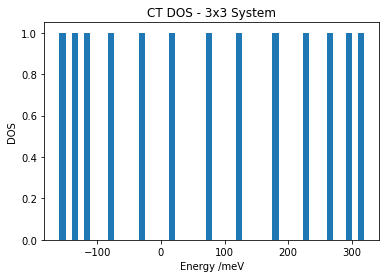

In [162]:
CT_eigenvals, CT_eigenvecs = get_eigen(H_CT)
plt.hist(CT_eigenvals, 50)
plt.title('CT DOS - 3x3 System')
plt.xlabel('Energy /meV')
plt.ylabel('DOS')

NameError: name 'eigenvals2' is not defined

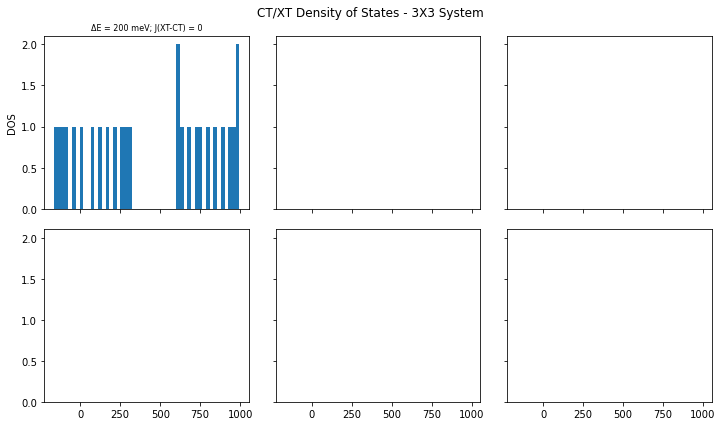

In [163]:
fig, axes = plt.subplots(nrows = 2,ncols = 3, sharex = True, sharey = True, figsize = (10,6))

fig.suptitle('CT/XT Density of States - 3X3 System')
fig.tight_layout()

axes[0,0].hist(eigenvals, 50)
axes[0,0].set_ylabel('DOS')
axes[0,0].set_title('\u0394E = 200 meV; J(XT-CT) = 0', fontsize = 8)

axes[1,0].hist(eigenvals2, 50)
axes[1,0].set_ylabel('DOS')
axes[1,0].set_xlabel('Energy /meV')
axes[1,0].set_title('\u0394E = 700 meV; J(XT-CT) = 0', fontsize = 8)

axes[0,1].hist(eigenvals3, 50)
axes[0,1].set_title('\u0394E = 200 meV; J(XT-CT) = 100', fontsize = 8)

axes[1,1].hist(eigenvals4, 50)
axes[1,1].set_xlabel('Energy /meV')
axes[1,1].set_title('\u0394E = 700 meV; J(XT-CT) = 100', fontsize = 8)

axes[0,2].hist(eigenvals5, 50)
axes[0,2].set_title('\u0394E = 200 meV; J(XT-CT) = 500', fontsize = 8)

axes[1,2].hist(eigenvals6, 50)
axes[1,2].set_xlabel('Energy /meV')
axes[1,2].set_title('\u0394E = 700 meV; J(XT-CT) = 500', fontsize = 8)

In [ ]:
for q in range(len(eigenvecs)):
    g, g2 = CT_site_populations(eigenvecs[:,q], dons, accs)
    #g, g2 = integrated_CT_populations(g, g2, 3)
    #print(np.sum(g))

[0.7200490402274262] [0.4767555067188778, 0.17241718499843142, 0.05173584111722118, 0.014204443370215302, 0.0037020723491528467, 0.0009323735103855195, 0.00022918497632398185, 5.5316091105570405e-05, 1.315506625493767e-05, 3.0832915795646646e-06, 7.057008016606248e-07, 1.501789550305633e-07, 2.2858121246558328e-08]
[0.9804677970232305] [0.013975555572869376, 0.0030581839956365054, 0.04376087715341461, 0.10104989389206567, 0.1443767549421518, 0.16174729707105553, 0.1547247207028552, 0.13102412329186772, 0.0993695159134224, 0.06695341587067248, 0.038684943588960616, 0.017385706688963238, 0.0043568083392954565]
[0.96450230097891] [0.015656610705680144, 0.014175559501483448, 0.09009121894342491, 0.13239733440471135, 0.09644210193055894, 0.029001635195111893, 0.00016638153918423432, 0.03728746290156746, 0.10976660532675585, 0.16105111036740533, 0.15398376026684768, 0.0956798879582167, 0.028802631937962016]
[0.49939335941460034] [0.0017445226297463667, 0.033474150224482274, 0.069883745409400

In [164]:
for j in range(len(XT_states)+1):
    t = XT_site_populations(eigenvecs[:,j], XT_states)
    #s = integrated_XT_populations(t, 3)
    #print(s)
    #print(np.sum(s))

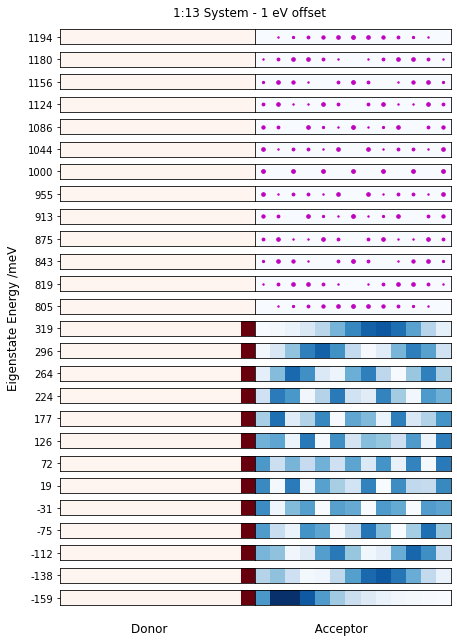

In [177]:
fig, axs = plt.subplots(nrows = len(eigenvecs), ncols = 2, sharex = True, figsize = (7,9))

#loop and select few eigenvectors
count = 0
for vector in np.flipud(eigenvecs.T): 
    
    # you could loop and calculate this for all the eigenvectors
    donor_populations, acceptor_populations =  CT_site_populations(vector, dons, accs)
    exciton_populations = XT_site_populations(vector, XT_states)

    #integrated_donor_populations, integrated_acceptor_populations = integrated_CT_populations(donor_populations, acceptor_populations, 1)
    #integrated_excitons = integrated_XT_populations(exciton_populations, 1)

    #integrated_donor_populations = np.array([integrated_donor_populations])
    #integrated_acceptor_populations = np.array([integrated_acceptor_populations])

    buffer = np.zeros((1, len(accs)))
    buffer[0][-1] = donor_populations[0]
    donor_populations = buffer

    axs[count,0].imshow(donor_populations, cmap = 'Reds', vmin = 0, vmax = 0.1)
    #axs[j,0].yaxis.set_visible(False)
    axs[count,0].xaxis.set_visible(False)
    axs[count,0].set_yticks([0])
    axs[count,0].set_yticklabels([int(eigenvals[-(count+1)])])

    axs[count,1].imshow(np.array([acceptor_populations]), cmap = 'Blues', vmin = 0, vmax = 0.2)
    axs[count,1].yaxis.set_visible(False)
    axs[count,1].xaxis.set_visible(False)

    for i in range(len(exciton_populations)):

        axs[count,1].scatter(i, 0, c = 'm', s = int(100*exciton_populations[i]))

    count += 1 

plt.ylabel('Energy')

fig.supylabel('Eigenstate Energy /meV')
fig.supxlabel('Donor                                      Acceptor')
fig.suptitle('1:13 System - 1 eV offset')
plt.subplots_adjust(wspace = 0, hspace = 0, bottom=0.05, top=0.95)